<a href="https://colab.research.google.com/github/rushirajsherlocked/Digital-Image-Processing-using-Python/blob/master/TextureAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Albumentations for a semantic segmentation task

We will use images and data from the [TGS Salt Identification Challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge).

## Prepare the Google Colab environment

#### Download images

Download images that are used in the notebook and save to the `images` folder in the Colab environment.

In [ ]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

Images are successfully downloaded


#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 71kB 2.7MB/s 
     |████████████████████████████████| 36.7MB 116kB/s 
     |████████████████████████████████| 952kB 48.8MB/s 
albumentations==0.5.0 is successfully installed


## Run the example

### Import the required libraries

In [ ]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

### Define a function to visualize images and masks

In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

### Read an image and its mask from the disk

In [ ]:
image = cv2.imread('/content/Images/f1.png')
mask = cv2.imread('/content/Masks/f1.png_annotation.ome.tiff', cv2.IMREAD_GRAYSCALE)

## Original image <a class="anchor" id="original-image"></a>

In [ ]:
print(image.shape, mask.shape)

(359, 709, 3) (359, 709)


In [ ]:
original_height, original_width = image.shape[:2]

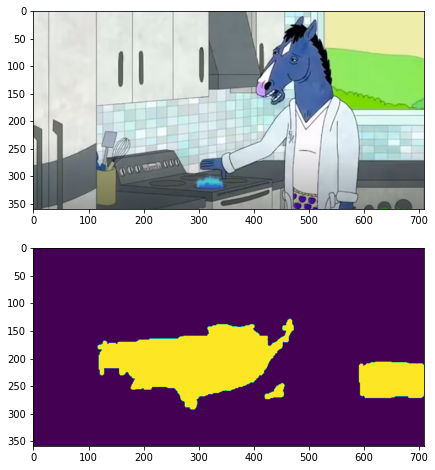

In [ ]:
visualize(image, mask)

 # Padding

UNet type architecture requires input image size be divisible by $2^N$, where $N$ is the number of maxpooling layers. In the vanilla UNet $N=5$  $\Longrightarrow$, we need to pad input images to the closest divisible by $2^5 = 32$ number, which is 128. This operation may be performed using [**PadIfNeeded**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.PadIfNeeded) transformation. It pads both the image and the mask on all four sides. Padding type (zero, constant, reflection) may be specified. The default padding is reflection padding.

(359, 709, 3) (359, 709)


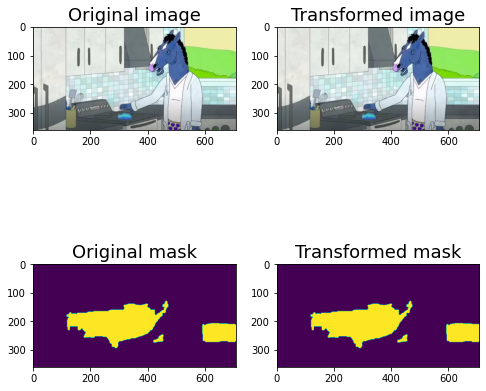

In [ ]:
aug = A.PadIfNeeded(min_height=128, min_width=128, p=1)

augmented = aug(image=image, mask=mask)

image_padded = augmented['image']
mask_padded = augmented['mask']

print(image_padded.shape, mask_padded.shape)

visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

# CenterCrop and Crop

To get to the original image and mask from the padded version, we may use [**CenterCrop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CenterCrop) or [**Crop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Crop) transformations.

(359, 709, 3) (359, 709)


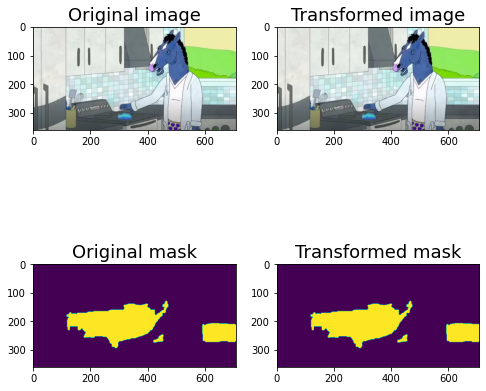

In [ ]:
aug = A.CenterCrop(p=1, height=original_height, width=original_width)

augmented = aug(image=image_padded, mask=mask_padded)

image_center_cropped = augmented['image']
mask_center_cropped = augmented['mask']

print(image_center_cropped.shape, mask_center_cropped.shape)

assert (image - image_center_cropped).sum() == 0
assert (mask - mask_center_cropped).sum() == 0

visualize(image_padded, mask_padded, original_image=image_center_cropped, original_mask=mask_center_cropped)

In [ ]:
x_min = (750 - original_width) // 2
y_min = (400- original_height) // 2

x_max = x_min + original_width
y_max = y_min + original_height

aug = A.Crop(x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, p=1)

augmented = aug(image=image_padded, mask=mask_padded)

image_cropped = augmented['image']
mask_cropped = augmented['mask']

print(image_cropped.shape, mask_cropped.shape)

assert (image - image_cropped).sum() == 0
assert (mask - mask_cropped).sum() == 0

visualize(image_cropped, mask_cropped, original_image=image_padded, original_mask=mask_padded)

ValueError: ignored

# Non destructive transformations. [Dehidral group D4](https://en.wikipedia.org/wiki/Dihedral_group)

For images for which there is no clear notion of top like this one, satellite and aerial imagery or medical imagery is typically a good idea to add transformations that do not add or lose the information.

There are eight distinct ways to represent the same square on the plane.

![D4](https://habrastorage.org/webt/ln/nw/nc/lnnwncjfjsn8zpfo6igvqq-rjky.png)

Combinations of the transformations [HorizontalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.HorizontalFlip), [VerticalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.VerticalFlip), [Transpose](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Transpose), [RandomRotate90](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomRotate90) will be able to get the original image to all eight states.

 ## HorizontalFlip

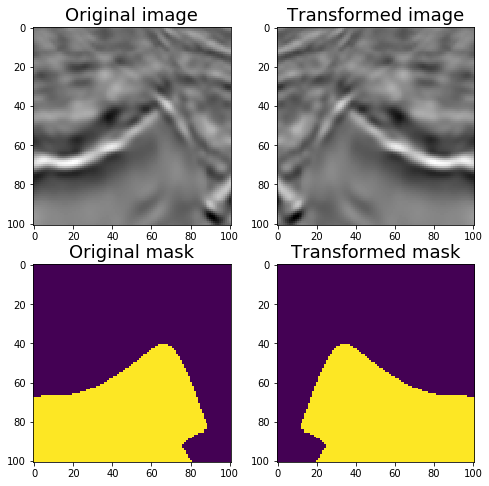

In [ ]:
aug = A.HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

## VerticalFlip

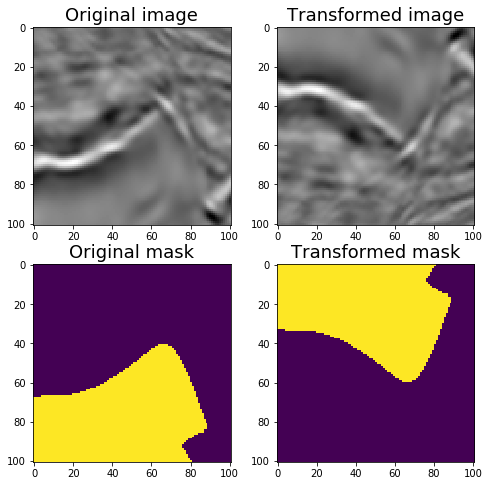

In [ ]:
aug = A.VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

## RandomRotate90 (Randomly rotates by 0, 90, 180, 270 degrees)

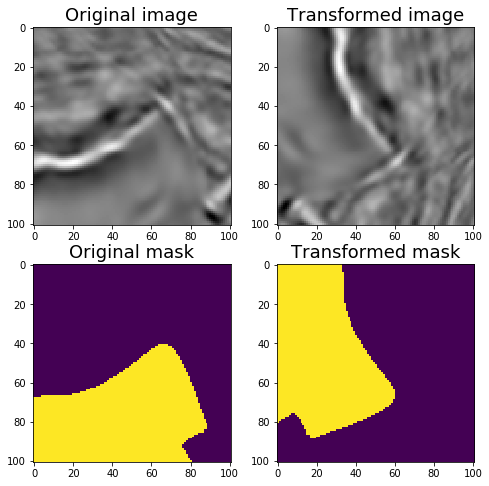

In [ ]:
aug = A.RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)

 ## Transpose (switch X and Y axis) 

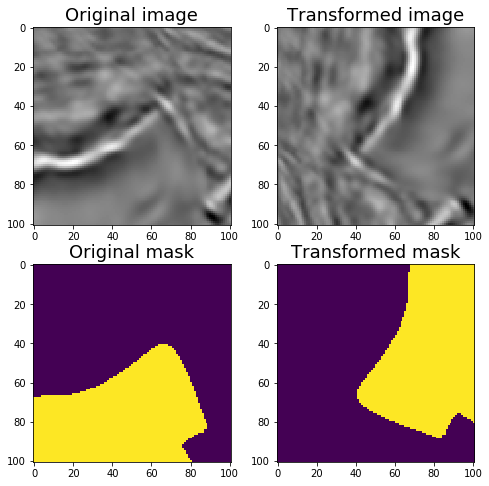

In [ ]:
aug = A.Transpose(p=1)

augmented = aug(image=image, mask=mask)

image_transposed = augmented['image']
mask_transposed = augmented['mask']

visualize(image_transposed, mask_transposed, original_image=image, original_mask=mask)

# Non-rigid transformations: ElasticTransform, GridDistortion, OpticalDistortion

In medical imaging problems, non-rigid transformations help to augment the data. It is unclear if they will help with this problem, but let's look at them. We will consider [ElasticTransform](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ElasticTransform), [GridDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.GridDistortion), [OpticalDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.OpticalDistortion).

We fix the random seed for visualization purposes, so the augmentation will always produce the same result. In a real computer vision pipeline, you shouldn't fix the random seed before applying a transform to the image because, in that case, the pipeline will always output the same image. The purpose of image augmentation is to use different transformations each time.

### ElasticTransform

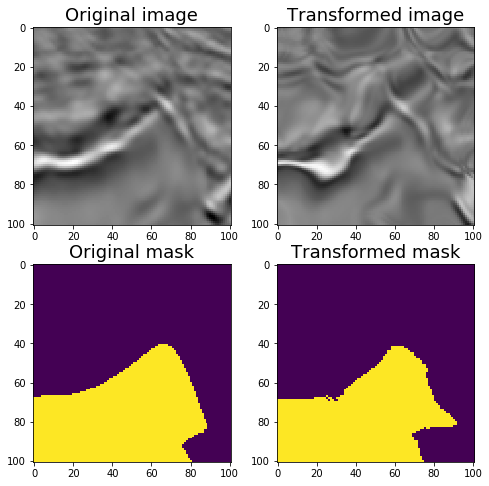

In [ ]:
aug = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)

### GridDistortion

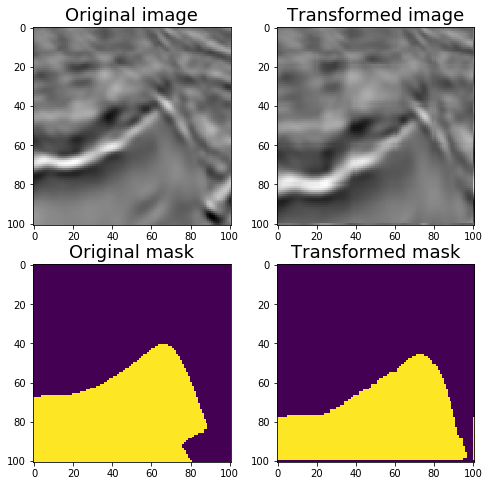

In [ ]:
aug = A.GridDistortion(p=1)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_grid = augmented['image']
mask_grid = augmented['mask']

visualize(image_grid, mask_grid, original_image=image, original_mask=mask)

### OpticalDistortion

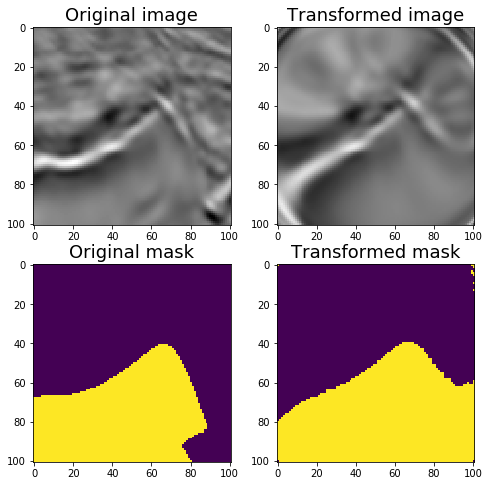

In [ ]:
aug = A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_optical = augmented['image']
mask_optical = augmented['mask']

visualize(image_optical, mask_optical, original_image=image, original_mask=mask)

# RandomSizedCrop

One may combine [RandomCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomCrop) and [RandomScale](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomScale) but there is a transformation [RandomSizedCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomSizedCrop) that allows to combine them into one transformation.

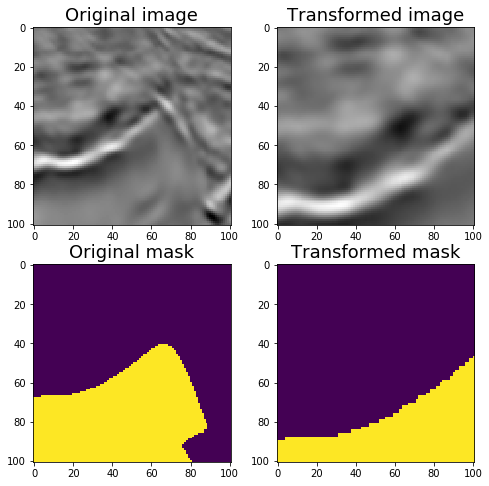

In [ ]:
aug = A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=1)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize(image_scaled, mask_scaled, original_image=image, original_mask=mask)

# Let's try to combine different transformations

Light non-destructive augmentations.

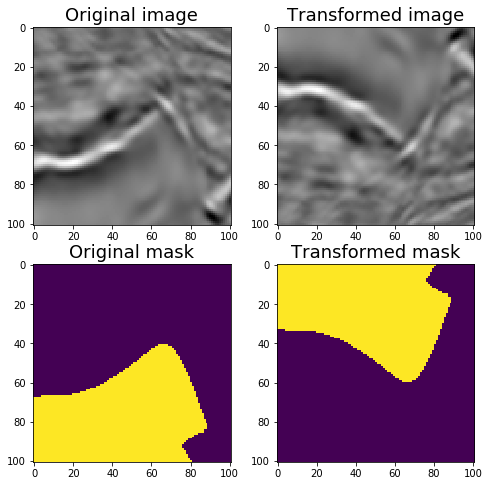

In [ ]:
aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5)]
)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_light = augmented['image']
mask_light = augmented['mask']

visualize(image_light, mask_light, original_image=image, original_mask=mask)

# Let's add non rigid transformations and RandomSizedCrop

## Medium augmentations

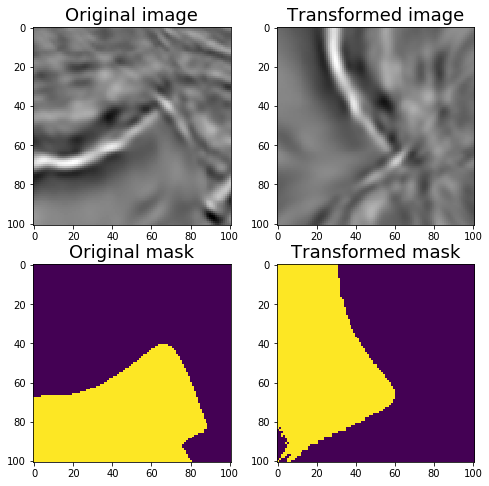

In [ ]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ],p=1),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)])

random.seed(11)
augmented = aug(image=image, mask=mask)

image_medium = augmented['image']
mask_medium = augmented['mask']

visualize(image_medium, mask_medium, original_image=image, original_mask=mask)

# Let's add non-spatial stransformations.

Many non-spatial transformations like [CLAHE](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CLAHE), [RandomBrightness](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomBrightness), [RandomContrast](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomContrast), [RandomGamma](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomGamma) can be also added. They will be applied only to the image and not the mask.

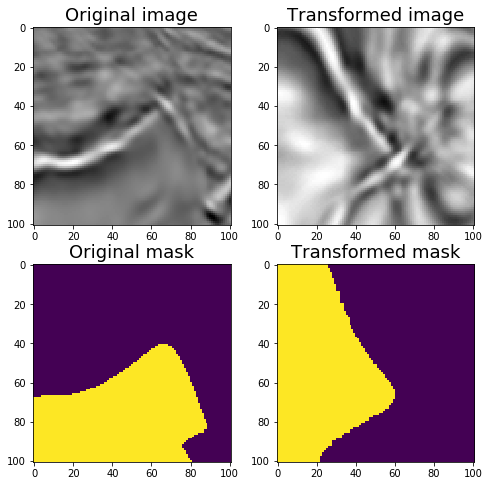

In [ ]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ], p=1),    
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)])

random.seed(11)
augmented = aug(image=image, mask=mask)

image_heavy = augmented['image']
mask_heavy = augmented['mask']

visualize(image_heavy, mask_heavy, original_image=image, original_mask=mask)